# Recommendation System using collaborative filtering

In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
import keras as keras
from scipy.sparse import csr_matrix
import tensorflow_probability as tfp
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error
import random
import math 
import matplotlib.pyplot as plt
from bs4 import BeautifulSoup
import requests

Read dataset from https://grouplens.org/datasets/movielens/latest/

In [2]:
ratings_data =  pd.read_csv('./dataset/ratings.csv')

In [3]:
ratings_data.head()

,user_id,movie_id,rating
0,1,1,4.0
1,1,3,4.0
2,1,6,4.0
3,1,47,5.0
4,1,50,5.0


In [4]:
ratings_data.describe()

,user_id,movie_id,rating
count,100836.000000,100836.000000,100836.000000
mean,326.127564,19435.295718,3.501557
std,182.618491,35530.987199,1.042529
min,1.000000,1.000000,0.500000
25%,177.000000,1199.000000,3.000000
50%,325.000000,2991.000000,3.500000
75%,477.000000,8122.000000,4.000000
max,610.000000,193609.000000,5.000000


In [5]:
ratings_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100836 entries, 0 to 100835
Data columns (total 3 columns):
 #   Column    Non-Null Count   Dtype  
---  ------    --------------   -----  
 0   user_id   100836 non-null  int64  
 1   movie_id  100836 non-null  int64  
 2   rating    100836 non-null  float64
dtypes: float64(1), int64(2)
memory usage: 2.3 MB


In [6]:
print("no of ratings:", ratings_data.shape[0])
print("no of unique users:",ratings_data.user_id.unique().shape[0])
print("no of unique movies:", ratings_data.movie_id.unique().shape[0])
print("maximum rating:", ratings_data.rating.max())
print("minimum rating:", ratings_data.rating.min())

no of ratings: 100836
no of unique users: 610
no of unique movies: 9724
maximum rating: 5.0
minimum rating: 0.5


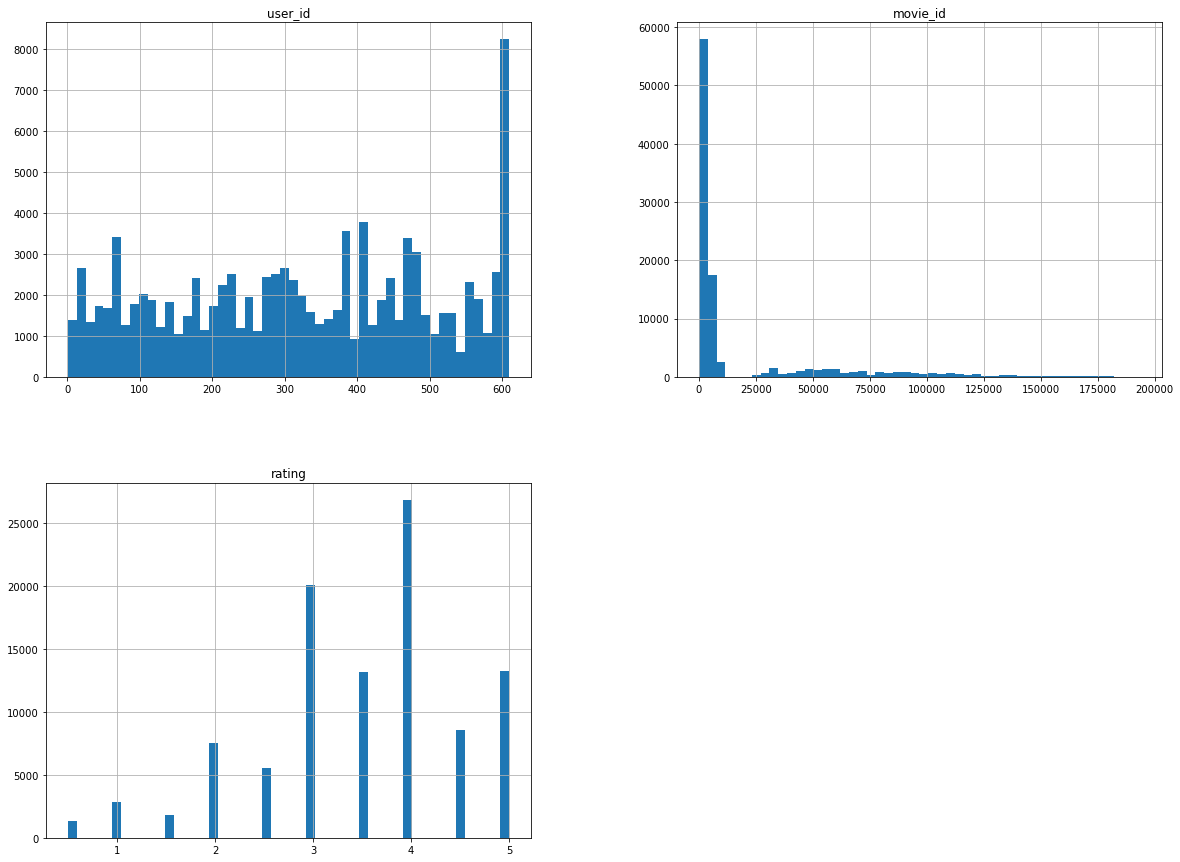

In [7]:
ratings_data.hist(bins=50, figsize=(20,15))
plt.show()

In [8]:
ratings_data[ratings_data.movie_id == 1251]

,user_id,movie_id,rating
7152,50,1251,4.5
12049,74,1251,4.5
22819,156,1251,5.0
25061,177,1251,3.0
26289,182,1251,5.0
38011,260,1251,3.0
48722,315,1251,4.0
52763,346,1251,3.0
56691,377,1251,4.5
59437,387,1251,4.5


In [9]:
def get_bad_index(ratings_data, number):
    data = {'user_id' : [], 'movie_id' : [], 'rating': []}
    bad_movies = pd.DataFrame (data, columns = ['user_id','movie_id', 'rating'])

    count_values = ratings_data['movie_id'].value_counts()
    bad_movies_index = []

    for index, row in ratings_data.iterrows():
        if count_values[row['movie_id']] <= number:
            bad_movies_index.append(index)
            bad_movies = bad_movies.append(row, ignore_index=True)
            bad_movies.user_id = bad_movies.user_id.astype('int64')
            bad_movies.movie_id = bad_movies.movie_id.astype('int64')
    return bad_movies, bad_movies_index
get_bad_index(ratings_data,1)[0]

,user_id,movie_id,rating
0,1,1473,4.0
1,2,131724,5.0
2,3,5746,5.0
3,3,5764,4.5
4,3,6835,5.0
...,...,...,...
3441,610,160341,2.5
3442,610,160527,4.5
3443,610,160836,3.0
3444,610,163937,3.5


In [10]:
def get_bad_user(ratings_data, number):
    data = {'user_id' : [], 'movie_id' : [], 'rating': []}
    bad_users = pd.DataFrame (data, columns = ['user_id','movie_id', 'rating'])

    count_values = ratings_data['user_id'].value_counts()
    bad_users_index = []

    for index, row in ratings_data.iterrows():
        if count_values[row['user_id']] < number:
            bad_users_index.append(index)
            bad_users = bad_movies.append(row, ignore_index=True)
            bad_users.user_id = bad_movies.user_id.astype('int64')
            bad_users.movie_id = bad_movies.movie_id.astype('int64')
    return bad_users, bad_users_index
get_bad_user(ratings_data,1)[0]

,user_id,movie_id,rating


In [11]:
ratings_data = ratings_data.drop(get_bad_index(ratings_data,1)[1])

In [12]:
print("no of ratings:", ratings_data.shape[0])
print("no of unique users:",ratings_data.user_id.unique().shape[0])
print("no of unique movies:", ratings_data.movie_id.unique().shape[0])
print("maximum rating:", ratings_data.rating.max())
print("minimum rating:", ratings_data.rating.min())

no of ratings: 97390
no of unique users: 610
no of unique movies: 6278
maximum rating: 5.0
minimum rating: 0.5


In [13]:
train_data, test_data = train_test_split(ratings_data, test_size=0.2, stratify=ratings_data.movie_id, random_state=10)

In [14]:
train_data.movie_id.unique().shape[0]

6278

# Matrix factorization

 Using matrix factorization, we can find some latent features that can determine how a user rates a movie. We decompose the matrix into constituent parts in such a way that the product of these parts generates the original matrix.

Obs:

    tf.random.normal = random samples from a normal Gaussian distribution. 

In [15]:
def build_sparse_tensor(np_array, indices, shape):
  return tf.SparseTensor(
                indices=indices,
                values=np_array,
                dense_shape=[shape[0], shape[1]])

In [16]:
class MF_tensorflow():
  # Initializing the user-movie rating matrix, no. of latent features, alpha - learning rate and beta - regularization parameter for bias.
    def __init__(self, R, K, alpha, iterations, beta):
        self.R = R
        self.num_users, self.num_items = R.dense_shape #tupla
        self.K = K
        self.alpha = alpha
        self.iterations = iterations
        self.optimizer = tf.optimizers.Adam(alpha)
        self.beta = beta

    # Initializing user-feature and movie-feature matrix 
    def train(self):
        self.P = tf.Variable(tf.random.normal(shape = [self.num_users, self.K]), dtype=tf.float32, trainable=True)
        self.Q = tf.Variable(tf.random.normal(shape = [self.K, self.num_items]), dtype=tf.float32, trainable=True)

        nr_validation = 10

        # Stochastic gradient descent for given number of iterations
        training_process = []
        propr = (self.K, self.alpha, self.beta)

        loss_hist = np.zeros(nr_validation, np.float32)

        for i in range(self.iterations):
          loss = lambda: tf.reduce_sum(tf.losses.mean_squared_error(self.R.values, tf.gather_nd(tf.matmul(self.P, self.Q),self.R.indices))) + self.regularizationL2()
            
          self.optimizer.minimize(loss, var_list = [self.P, self.Q])

          nrmse = loss()
          training_process = (propr,i, nrmse)
          loss_hist[i%nr_validation] = nrmse
          if i % nr_validation == 0 and i != 0:
            if loss_hist[nr_validation - 1] - loss_hist[1] >= 0:
              print(i)
              print(32*"-")
              print(loss_hist)
              return (propr,i, loss_hist[nr_validation - 1])
              break

          if (i+1) % 25 == 0:
            print("Iteration: %d ; error = %.4f; " % (i+1, nrmse))


        return training_process

    def mse(self):
      predictions_matrix = tf.gather_nd(self.full_matrix(),self.R.indices)
      predictions_matrix = build_sparse_tensor(predictions_matrix, self.R.indices, self.R.dense_shape)
      mse = tf.keras.losses.MeanSquaredError()
      return mse(tf.sparse.to_dense(self.R), tf.sparse.to_dense(predictions_matrix)).numpy()

    def regularizationL1(self):
      abs_P = tf.abs(self.P)
      abs_Q = tf.abs(self.Q)
      sum_P = tf.reduce_sum(abs_P)
      sum_Q = tf.reduce_sum(abs_Q)

      return (sum_Q + sum_P) * self.beta

    def regularizationL2(self):
      pow_P = tf.pow(self.P,2)
      pow_Q = tf.pow(self.Q,2)
      sum_P = tf.reduce_sum(pow_P)
      sum_Q = tf.reduce_sum(pow_Q)

      return (sum_Q + sum_P) * self.beta

     # Full user-movie matrix
    def full_matrix(self):
        return tf.matmul(self.P,self.Q)

In [17]:
R= np.array(train_data.pivot(index = 'user_id', columns ='movie_id', values = 'rating').fillna(0))
indices = [[i, j] for i in range(R.shape[0]) for j in range(R.shape[1]) if R[i, j] > 0]
shape = R.shape
R = build_sparse_tensor(np.array(train_data.rating, dtype=np.float32), indices, shape)

In [18]:
mf = MF_tensorflow(R, K=20, alpha= 0.0003, iterations=50000, beta = 0.0001)
training_process = mf.train()  
print()
print("P x Q:")
print(mf.full_matrix())
print()

Iteration: 25 ; error = 45.7876; 
Iteration: 50 ; error = 45.0535; 
Iteration: 75 ; error = 44.3418; 
Iteration: 100 ; error = 43.6518; 
Iteration: 125 ; error = 42.9826; 
Iteration: 150 ; error = 42.3331; 
Iteration: 175 ; error = 41.7024; 
Iteration: 200 ; error = 41.0897; 
Iteration: 225 ; error = 40.4942; 
Iteration: 250 ; error = 39.9150; 
Iteration: 275 ; error = 39.3516; 
Iteration: 300 ; error = 38.8032; 
Iteration: 325 ; error = 38.2691; 
Iteration: 350 ; error = 37.7489; 
Iteration: 375 ; error = 37.2418; 
Iteration: 400 ; error = 36.7473; 
Iteration: 425 ; error = 36.2650; 
Iteration: 450 ; error = 35.7943; 
Iteration: 475 ; error = 35.3347; 
Iteration: 500 ; error = 34.8858; 
Iteration: 525 ; error = 34.4471; 
Iteration: 550 ; error = 34.0181; 
Iteration: 575 ; error = 33.5986; 
Iteration: 600 ; error = 33.1880; 
Iteration: 625 ; error = 32.7859; 
Iteration: 650 ; error = 32.3921; 
Iteration: 675 ; error = 32.0060; 
Iteration: 700 ; error = 31.6274; 
Iteration: 725 ; error 

Iteration: 5850 ; error = 3.3775; 
Iteration: 5875 ; error = 3.3566; 
Iteration: 5900 ; error = 3.3359; 
Iteration: 5925 ; error = 3.3155; 
Iteration: 5950 ; error = 3.2954; 
Iteration: 5975 ; error = 3.2756; 
Iteration: 6000 ; error = 3.2559; 
Iteration: 6025 ; error = 3.2366; 
Iteration: 6050 ; error = 3.2175; 
Iteration: 6075 ; error = 3.1986; 
Iteration: 6100 ; error = 3.1800; 
Iteration: 6125 ; error = 3.1616; 
Iteration: 6150 ; error = 3.1434; 
Iteration: 6175 ; error = 3.1255; 
Iteration: 6200 ; error = 3.1078; 
Iteration: 6225 ; error = 3.0903; 
Iteration: 6250 ; error = 3.0730; 
Iteration: 6275 ; error = 3.0560; 
Iteration: 6300 ; error = 3.0392; 
Iteration: 6325 ; error = 3.0225; 
Iteration: 6350 ; error = 3.0061; 
Iteration: 6375 ; error = 2.9900; 
Iteration: 6400 ; error = 2.9740; 
Iteration: 6425 ; error = 2.9582; 
Iteration: 6450 ; error = 2.9426; 
Iteration: 6475 ; error = 2.9272; 
Iteration: 6500 ; error = 2.9120; 
Iteration: 6525 ; error = 2.8970; 
Iteration: 6550 ; er

Iteration: 11675 ; error = 1.8382; 
Iteration: 11700 ; error = 1.8373; 
Iteration: 11725 ; error = 1.8365; 
Iteration: 11750 ; error = 1.8356; 
Iteration: 11775 ; error = 1.8348; 
Iteration: 11800 ; error = 1.8340; 
Iteration: 11825 ; error = 1.8332; 
Iteration: 11850 ; error = 1.8324; 
Iteration: 11875 ; error = 1.8317; 
Iteration: 11900 ; error = 1.8309; 
Iteration: 11925 ; error = 1.8302; 
Iteration: 11950 ; error = 1.8294; 
Iteration: 11975 ; error = 1.8287; 
Iteration: 12000 ; error = 1.8280; 
Iteration: 12025 ; error = 1.8273; 
Iteration: 12050 ; error = 1.8266; 
Iteration: 12075 ; error = 1.8259; 
Iteration: 12100 ; error = 1.8252; 
Iteration: 12125 ; error = 1.8246; 
Iteration: 12150 ; error = 1.8239; 
Iteration: 12175 ; error = 1.8233; 
Iteration: 12200 ; error = 1.8226; 
Iteration: 12225 ; error = 1.8220; 
Iteration: 12250 ; error = 1.8214; 
Iteration: 12275 ; error = 1.8208; 
Iteration: 12300 ; error = 1.8202; 
Iteration: 12325 ; error = 1.8196; 
Iteration: 12350 ; error = 1

Iteration: 17375 ; error = 1.7805; 
Iteration: 17400 ; error = 1.7805; 
Iteration: 17425 ; error = 1.7804; 
Iteration: 17450 ; error = 1.7804; 
Iteration: 17475 ; error = 1.7803; 
Iteration: 17500 ; error = 1.7803; 
Iteration: 17525 ; error = 1.7803; 
Iteration: 17550 ; error = 1.7802; 
Iteration: 17575 ; error = 1.7802; 
Iteration: 17600 ; error = 1.7802; 
Iteration: 17625 ; error = 1.7801; 
Iteration: 17650 ; error = 1.7801; 
Iteration: 17675 ; error = 1.7800; 
Iteration: 17700 ; error = 1.7800; 
Iteration: 17725 ; error = 1.7800; 
Iteration: 17750 ; error = 1.7799; 
Iteration: 17775 ; error = 1.7799; 
Iteration: 17800 ; error = 1.7799; 
Iteration: 17825 ; error = 1.7798; 
Iteration: 17850 ; error = 1.7798; 
Iteration: 17875 ; error = 1.7798; 
Iteration: 17900 ; error = 1.7797; 
Iteration: 17925 ; error = 1.7797; 
Iteration: 17950 ; error = 1.7797; 
Iteration: 17975 ; error = 1.7796; 
Iteration: 18000 ; error = 1.7796; 
Iteration: 18025 ; error = 1.7796; 
Iteration: 18050 ; error = 1

Iteration: 23075 ; error = 1.7766; 
Iteration: 23100 ; error = 1.7766; 
Iteration: 23125 ; error = 1.7766; 
Iteration: 23150 ; error = 1.7766; 
Iteration: 23175 ; error = 1.7766; 
Iteration: 23200 ; error = 1.7766; 
Iteration: 23225 ; error = 1.7766; 
Iteration: 23250 ; error = 1.7766; 
Iteration: 23275 ; error = 1.7766; 
Iteration: 23300 ; error = 1.7766; 
Iteration: 23325 ; error = 1.7766; 
Iteration: 23350 ; error = 1.7766; 
Iteration: 23375 ; error = 1.7766; 
Iteration: 23400 ; error = 1.7765; 
Iteration: 23425 ; error = 1.7765; 
Iteration: 23450 ; error = 1.7765; 
Iteration: 23475 ; error = 1.7765; 
Iteration: 23500 ; error = 1.7765; 
Iteration: 23525 ; error = 1.7765; 
Iteration: 23550 ; error = 1.7765; 
Iteration: 23575 ; error = 1.7765; 
Iteration: 23600 ; error = 1.7765; 
Iteration: 23625 ; error = 1.7765; 
Iteration: 23650 ; error = 1.7765; 
Iteration: 23675 ; error = 1.7765; 
Iteration: 23700 ; error = 1.7765; 
Iteration: 23725 ; error = 1.7765; 
Iteration: 23750 ; error = 1

Evaluation:

In [19]:
test_tensor = np.array(test_data.pivot(index = 'user_id', columns ='movie_id', values = 'rating').fillna(0))
indices = [[i, j] for i in range(test_tensor.shape[0]) for j in range(test_tensor.shape[1]) if test_tensor[i, j] > 0]
shape = test_tensor.shape
test_tensor = build_sparse_tensor(np.array(test_data.rating, dtype=np.float32), indices, shape)
test_tensor.values

<tf.Tensor: shape=(19478,), dtype=float32, numpy=array([1. , 4. , 4. , ..., 4. , 3.5, 1.5], dtype=float32)>

In [20]:
predictions_matrix = build_sparse_tensor(tf.gather_nd(mf.full_matrix(),test_tensor.indices), test_tensor.indices, test_tensor.dense_shape)
m = tf.keras.metrics.RootMeanSquaredError()
error = tf.reduce_sum(tf.losses.mean_squared_error(tf.sparse.to_dense(test_tensor), tf.sparse.to_dense(predictions_matrix)))
res = m.update_state(tf.sparse.to_dense(test_tensor), tf.sparse.to_dense(predictions_matrix))
print(m.result().numpy())
error

0.13937409


<tf.Tensor: shape=(), dtype=float32, numpy=11.829908>

In [21]:
loss = tf.reduce_sum(tf.keras.losses.mean_absolute_error(tf.sparse.to_dense(test_tensor), tf.sparse.to_dense(predictions_matrix)))
loss 

<tf.Tensor: shape=(), dtype=float32, numpy=5.596728>

In [22]:
mean_absolute_error(tf.sparse.to_dense(test_tensor), tf.sparse.to_dense(predictions_matrix))

0.0091900285

## Recommendation for a group

In [23]:
def take_index_from_prediction_matrix(data, prediction_index):
    movies_index = data.movie_id.unique()
    movies_index.sort()
    
    return movies_index[prediction_index]
        
take_index_from_prediction_matrix(train_data, 0)

1

In [24]:
def create_index_movies(userId, data):
    movies = len(data.movie_id.unique())
    index = []
    
    for i in range(movies):
        index.append([userId, i])
    return index

In [25]:
def takeSecond(elem):
    return elem[1]

In [26]:
def get_prediction_for_group(usersIds, data, predictions, noOfRecomm):
    indexes = []
    mov_ratings = []
    
    for user in usersIds:
        indexes.append((user, create_index_movies(user, data)))
    
    for i in range(len(indexes)):
        index = indexes[i]
        mov_ratings.append((tf.gather_nd(predictions, index[1]).numpy().tolist()))

    average = []
    
    for j in range(len(data.movie_id.unique())):
        sum = 0
        k = 0
        for i in range(len(usersIds)):
            sum += mov_ratings[i][j]
            k+=1
        
        average.append((j, (sum/k)))
    
    average.sort(key=takeSecond, reverse=True)
    recomm = []
    
    for i in range(noOfRecomm):
        recomm.append(take_index_from_prediction_matrix(data, average[i][0])) 

    return recomm
    
get_prediction_for_group([0,1], train_data, mf.full_matrix(), 10)

[539, 1200, 364, 377, 442, 150, 420, 6333, 592, 110]

In [27]:
def get_movies_for_user(usersIds, data, predictions):
    movies = {}
    indexes = []
    mov_ratings = []
    
    for user in usersIds:
        indexes.append((user, create_index_movies(user, data)))
        movies[user] = []
    
    for i in range(len(indexes)):
        index = indexes[i]
        mov_ratings.append((tf.gather_nd(predictions, index[1]).numpy().tolist()))

    
    for j in range(len(data.movie_id.unique())):
        for i in range(len(usersIds)):
            movies[i].append((take_index_from_prediction_matrix(data, j), mov_ratings[i][j]))

    return movies

ids = [0,1]
all_movies_for_ids = get_movies_for_user(ids, train_data, mf.full_matrix())
all_movies_for_ids

{0: [(1, 4.097227573394775),
  (2, 3.7943801879882812),
  (3, 4.122756481170654),
  (4, 3.890615224838257),
  (5, 4.029921054840088),
  (6, 3.4768447875976562),
  (7, 2.284567356109619),
  (8, 3.4881794452667236),
  (9, 3.4949958324432373),
  (10, 4.140031337738037),
  (11, 3.583552598953247),
  (12, 3.27256178855896),
  (13, 2.4558420181274414),
  (14, 3.061023235321045),
  (15, 2.826261281967163),
  (16, 2.957268714904785),
  (17, 3.3124349117279053),
  (18, 3.6444132328033447),
  (19, 3.678269147872925),
  (20, 4.077176570892334),
  (21, 3.7083494663238525),
  (22, 3.9186642169952393),
  (23, 3.533597469329834),
  (24, 3.9445700645446777),
  (25, 2.702082633972168),
  (26, 3.193211793899536),
  (27, 2.9995317459106445),
  (28, 2.74371600151062),
  (29, 3.8408143520355225),
  (30, 2.150500535964966),
  (31, 3.1570868492126465),
  (32, 2.771653175354004),
  (34, 3.0299596786499023),
  (36, 3.1902620792388916),
  (38, 1.6554135084152222),
  (39, 4.183916091918945),
  (40, 2.87900018692

In [28]:
for i in range(len(all_movies_for_ids)):
    all_movies_for_ids[i].sort(key=lambda tup: tup[1])
all_movies_for_ids[0]

[(49524, 0.20405657589435577),
 (4470, 0.25091245770454407),
 (7440, 0.2966940999031067),
 (49132, 0.305974543094635),
 (4602, 0.3226935565471649),
 (4312, 0.3358340859413147),
 (3733, 0.35451173782348633),
 (159717, 0.37102875113487244),
 (33830, 0.37545591592788696),
 (6945, 0.37623557448387146),
 (45208, 0.3834597170352936),
 (731, 0.38411712646484375),
 (2844, 0.3874622583389282),
 (72405, 0.3969746232032776),
 (176751, 0.40325966477394104),
 (26778, 0.40733101963996887),
 (8830, 0.41408684849739075),
 (30820, 0.4173717796802521),
 (6517, 0.423140287399292),
 (60161, 0.43141552805900574),
 (50800, 0.4349190890789032),
 (118702, 0.4535558521747589),
 (6547, 0.46131306886672974),
 (4462, 0.4707186818122864),
 (90471, 0.49027830362319946),
 (7311, 0.4984099268913269),
 (99728, 0.4992075264453888),
 (5994, 0.5099571943283081),
 (48161, 0.5109835863113403),
 (4757, 0.5122004747390747),
 (7054, 0.5235340595245361),
 (8912, 0.5290388464927673),
 (3368, 0.5345776081085205),
 (114818, 0.534

In [29]:
def take__movie_ranks_for_all_ids(count, movieId):
    borda_number = 0
    for userId in range(len(count)):
        for i in range(len(count[userId])):
            if count[userId][i][0] == movieId:
                borda_number += count[userId][i][1]
                break
    
    return borda_number

In [30]:
def borda_count(movies, data, noOfRecommendation):
    count = {}
    for i in range(len(movies)):
        count[i] = []
    
    for userId in range(len(movies)):
        for i in range(len(movies[userId])):
            count[userId].append((movies[userId][i][0], i))
    
    borda_count = []
    for movieId in data.movie_id.unique():
        borda_count.append((movieId, take__movie_ranks_for_all_ids(count, movieId)))
    
    borda_count.sort(key=lambda tup: tup[1], reverse=True)
    
    recomm = []
    
    for i in range(noOfRecommendation):
        recomm.append(borda_count[i][0]) 

    return recomm
borda_count(all_movies_for_ids, train_data, 10)

[539, 150, 420, 364, 592, 588, 318, 1200, 653, 442]

## Similarity validation

- select 50 users (delete them from train data)
- take 5 random movie from each user you deleted from train data and calculate the similarity
- find out the error for the remaining movies
- try with average rating

In [31]:
# len(get_bad_index(ratings_data,5)[1])

In [32]:
# ratings_data = ratings_data.drop(get_bad_index(ratings_data,5)[1])

In [33]:
new_users = ratings_data[ratings_data['user_id'] >= 560] # last 50 users
new_users

,user_id,movie_id,rating
86124,560,1,3.0
86125,560,32,3.5
86126,560,34,2.5
86127,560,47,4.0
86128,560,48,2.5
...,...,...,...
100831,610,166534,4.0
100832,610,168248,5.0
100833,610,168250,5.0
100834,610,168252,5.0


In [34]:
len(get_bad_index(new_users, 1)[1])

1864

In [35]:
new_users = new_users.drop(get_bad_index(new_users,1)[1])
new_users

,user_id,movie_id,rating
86124,560,1,3.0
86125,560,32,3.5
86126,560,34,2.5
86127,560,47,4.0
86128,560,48,2.5
...,...,...,...
100830,610,166528,4.0
100831,610,166534,4.0
100832,610,168248,5.0
100833,610,168250,5.0


In [36]:
len(get_bad_user(new_users, 5)[1])

0

In [37]:
new_users = new_users.drop(get_bad_user(new_users,5)[1])
new_users

,user_id,movie_id,rating
86124,560,1,3.0
86125,560,32,3.5
86126,560,34,2.5
86127,560,47,4.0
86128,560,48,2.5
...,...,...,...
100830,610,166528,4.0
100831,610,166534,4.0
100832,610,168248,5.0
100833,610,168250,5.0


In [38]:
data = ratings_data[ratings_data['user_id'] < 560]
data

,user_id,movie_id,rating
0,1,1,4.0
1,1,3,4.0
2,1,6,4.0
3,1,47,5.0
4,1,50,5.0
...,...,...,...
86119,559,1429,3.0
86120,559,1527,5.0
86121,559,1544,3.0
86122,559,1566,4.0


In [39]:
len(get_bad_index(data, 1)[1])

530

In [40]:
data = data.drop(get_bad_index(data, 1)[1])

In [41]:
train_data_2, test_data_2 = train_test_split(data, test_size=0.2, stratify=data.movie_id, random_state=10)
train_data_2

,user_id,movie_id,rating
78845,489,4017,3.0
7234,50,7396,4.0
47269,307,4571,3.0
60248,387,54190,3.0
42839,288,3809,3.0
...,...,...,...
65687,422,3798,2.0
32335,221,1200,5.0
81303,514,3877,1.0
16681,105,69134,5.0


In [42]:
R2= np.array(train_data_2.pivot(index = 'user_id', columns ='movie_id', values = 'rating').fillna(0))
indices2 = [[i, j] for i in range(R2.shape[0]) for j in range(R2.shape[1]) if R2[i, j] > 0]
R2 = build_sparse_tensor(np.array(train_data_2.rating, dtype=np.float32), indices2, R2.shape)

In [43]:
mf = MF_tensorflow(R2, K=20, alpha= 0.0003, iterations=50000, beta = 0.0001)
training_process = mf.train()  
print()
print("P x Q:")
print(mf.full_matrix())
print()

Iteration: 25 ; error = 44.7107; 
Iteration: 50 ; error = 43.9828; 
Iteration: 75 ; error = 43.2775; 
Iteration: 100 ; error = 42.5939; 
Iteration: 125 ; error = 41.9312; 
Iteration: 150 ; error = 41.2883; 
Iteration: 175 ; error = 40.6642; 
Iteration: 200 ; error = 40.0582; 
Iteration: 225 ; error = 39.4693; 
Iteration: 250 ; error = 38.8968; 
Iteration: 275 ; error = 38.3401; 
Iteration: 300 ; error = 37.7983; 
Iteration: 325 ; error = 37.2708; 
Iteration: 350 ; error = 36.7571; 
Iteration: 375 ; error = 36.2564; 
Iteration: 400 ; error = 35.7684; 
Iteration: 425 ; error = 35.2924; 
Iteration: 450 ; error = 34.8279; 
Iteration: 475 ; error = 34.3745; 
Iteration: 500 ; error = 33.9316; 
Iteration: 525 ; error = 33.4988; 
Iteration: 550 ; error = 33.0756; 
Iteration: 575 ; error = 32.6617; 
Iteration: 600 ; error = 32.2566; 
Iteration: 625 ; error = 31.8600; 
Iteration: 650 ; error = 31.4713; 
Iteration: 675 ; error = 31.0903; 
Iteration: 700 ; error = 30.7166; 
Iteration: 725 ; error 

Iteration: 5850 ; error = 3.2339; 
Iteration: 5875 ; error = 3.2137; 
Iteration: 5900 ; error = 3.1938; 
Iteration: 5925 ; error = 3.1741; 
Iteration: 5950 ; error = 3.1546; 
Iteration: 5975 ; error = 3.1354; 
Iteration: 6000 ; error = 3.1165; 
Iteration: 6025 ; error = 3.0977; 
Iteration: 6050 ; error = 3.0792; 
Iteration: 6075 ; error = 3.0610; 
Iteration: 6100 ; error = 3.0430; 
Iteration: 6125 ; error = 3.0252; 
Iteration: 6150 ; error = 3.0076; 
Iteration: 6175 ; error = 2.9902; 
Iteration: 6200 ; error = 2.9731; 
Iteration: 6225 ; error = 2.9561; 
Iteration: 6250 ; error = 2.9394; 
Iteration: 6275 ; error = 2.9229; 
Iteration: 6300 ; error = 2.9066; 
Iteration: 6325 ; error = 2.8905; 
Iteration: 6350 ; error = 2.8747; 
Iteration: 6375 ; error = 2.8590; 
Iteration: 6400 ; error = 2.8435; 
Iteration: 6425 ; error = 2.8282; 
Iteration: 6450 ; error = 2.8131; 
Iteration: 6475 ; error = 2.7981; 
Iteration: 6500 ; error = 2.7834; 
Iteration: 6525 ; error = 2.7689; 
Iteration: 6550 ; er

Iteration: 11675 ; error = 1.7219; 
Iteration: 11700 ; error = 1.7210; 
Iteration: 11725 ; error = 1.7202; 
Iteration: 11750 ; error = 1.7194; 
Iteration: 11775 ; error = 1.7185; 
Iteration: 11800 ; error = 1.7177; 
Iteration: 11825 ; error = 1.7169; 
Iteration: 11850 ; error = 1.7161; 
Iteration: 11875 ; error = 1.7153; 
Iteration: 11900 ; error = 1.7146; 
Iteration: 11925 ; error = 1.7138; 
Iteration: 11950 ; error = 1.7131; 
Iteration: 11975 ; error = 1.7123; 
Iteration: 12000 ; error = 1.7116; 
Iteration: 12025 ; error = 1.7109; 
Iteration: 12050 ; error = 1.7102; 
Iteration: 12075 ; error = 1.7095; 
Iteration: 12100 ; error = 1.7088; 
Iteration: 12125 ; error = 1.7082; 
Iteration: 12150 ; error = 1.7075; 
Iteration: 12175 ; error = 1.7069; 
Iteration: 12200 ; error = 1.7062; 
Iteration: 12225 ; error = 1.7056; 
Iteration: 12250 ; error = 1.7050; 
Iteration: 12275 ; error = 1.7044; 
Iteration: 12300 ; error = 1.7038; 
Iteration: 12325 ; error = 1.7032; 
Iteration: 12350 ; error = 1

Iteration: 17375 ; error = 1.6607; 
Iteration: 17400 ; error = 1.6606; 
Iteration: 17425 ; error = 1.6605; 
Iteration: 17450 ; error = 1.6605; 
Iteration: 17475 ; error = 1.6604; 
Iteration: 17500 ; error = 1.6604; 
Iteration: 17525 ; error = 1.6603; 
Iteration: 17550 ; error = 1.6603; 
Iteration: 17575 ; error = 1.6602; 
Iteration: 17600 ; error = 1.6602; 
Iteration: 17625 ; error = 1.6601; 
Iteration: 17650 ; error = 1.6600; 
Iteration: 17675 ; error = 1.6600; 
Iteration: 17700 ; error = 1.6599; 
Iteration: 17725 ; error = 1.6599; 
Iteration: 17750 ; error = 1.6598; 
Iteration: 17775 ; error = 1.6598; 
Iteration: 17800 ; error = 1.6597; 
Iteration: 17825 ; error = 1.6597; 
Iteration: 17850 ; error = 1.6596; 
Iteration: 17875 ; error = 1.6596; 
Iteration: 17900 ; error = 1.6595; 
Iteration: 17925 ; error = 1.6595; 
Iteration: 17950 ; error = 1.6594; 
Iteration: 17975 ; error = 1.6594; 
Iteration: 18000 ; error = 1.6593; 
Iteration: 18025 ; error = 1.6593; 
Iteration: 18050 ; error = 1

Iteration: 23075 ; error = 1.6556; 
Iteration: 23100 ; error = 1.6555; 
Iteration: 23125 ; error = 1.6555; 
Iteration: 23150 ; error = 1.6555; 
Iteration: 23175 ; error = 1.6555; 
Iteration: 23200 ; error = 1.6554; 
Iteration: 23225 ; error = 1.6554; 
Iteration: 23250 ; error = 1.6554; 
Iteration: 23275 ; error = 1.6554; 
Iteration: 23300 ; error = 1.6553; 
Iteration: 23325 ; error = 1.6553; 
Iteration: 23350 ; error = 1.6553; 
Iteration: 23375 ; error = 1.6553; 
Iteration: 23400 ; error = 1.6552; 
Iteration: 23425 ; error = 1.6552; 
Iteration: 23450 ; error = 1.6552; 
Iteration: 23475 ; error = 1.6552; 
Iteration: 23500 ; error = 1.6552; 
Iteration: 23525 ; error = 1.6552; 
Iteration: 23550 ; error = 1.6551; 
Iteration: 23575 ; error = 1.6551; 
Iteration: 23600 ; error = 1.6551; 
Iteration: 23625 ; error = 1.6551; 
Iteration: 23650 ; error = 1.6551; 
Iteration: 23675 ; error = 1.6551; 
Iteration: 23700 ; error = 1.6550; 
Iteration: 23725 ; error = 1.6550; 
Iteration: 23750 ; error = 1

In [44]:
test_tensor = np.array(test_data_2.pivot(index = 'user_id', columns ='movie_id', values = 'rating').fillna(0))
indices = [[i, j] for i in range(test_tensor.shape[0]) for j in range(test_tensor.shape[1]) if test_tensor[i, j] > 0]
shape = test_tensor.shape
test_tensor = build_sparse_tensor(np.array(test_data_2.rating, dtype=np.float32), indices, shape)
test_tensor.indices

<tf.Tensor: shape=(16606, 2), dtype=int64, numpy=
array([[  0, 107],
       [  0, 113],
       [  0, 153],
       ...,
       [558, 697],
       [558, 836],
       [558, 852]], dtype=int64)>

In [45]:
predictions_matrix = build_sparse_tensor(tf.gather_nd(mf.full_matrix(),test_tensor.indices), test_tensor.indices, test_tensor.dense_shape)
m = tf.keras.metrics.RootMeanSquaredError()
error = tf.reduce_sum(tf.losses.mean_squared_error(tf.sparse.to_dense(test_tensor), tf.sparse.to_dense(predictions_matrix)))
res = m.update_state(tf.sparse.to_dense(test_tensor), tf.sparse.to_dense(predictions_matrix))
print(m.result().numpy())
error

0.1345493


<tf.Tensor: shape=(), dtype=float32, numpy=10.119866>

In [46]:
loss = tf.reduce_sum(tf.keras.losses.mean_absolute_error(tf.sparse.to_dense(test_tensor), tf.sparse.to_dense(predictions_matrix)))
loss 

<tf.Tensor: shape=(), dtype=float32, numpy=5.023982>

In [47]:
def take_random_5_movies_fromUser(userId):
    user_data = new_users[new_users['user_id'] == userId]
    all_movies = user_data['movie_id'].tolist()
    choosen_movies = []
    
    for i in range(5):
        rand = random.choice(all_movies)
        all_movies.remove(rand)
        choosen_movies.append(rand)
    return (userId, choosen_movies, all_movies)
take_random_5_movies_fromUser(560)[1]

[4383, 4015, 593, 3745, 4018]

In [48]:
def create_user_data(id):
    selected_user = take_random_5_movies_fromUser(id)

    data = {'user_id' : [], 'movie_id' : [], 'rating': []}
    selected_user_data = pd.DataFrame (data, columns = ['user_id','movie_id', 'rating'])

    
    for index, row in new_users[new_users['user_id'] == id].iterrows():
        for i in selected_user[1]:
            if row['movie_id'] == i:
                selected_user_data = selected_user_data.append(row, ignore_index=True)
                selected_user_data.user_id = selected_user_data.user_id.astype('int64')
                selected_user_data.movie_id = selected_user_data.movie_id.astype('int64')
        
    return selected_user_data, selected_user[2]

create_user_data(560)[0]

,user_id,movie_id,rating
0,560,8361,2.5
1,560,8529,3.5
2,560,8665,4.0
3,560,70286,4.0
4,560,89804,4.0


In [49]:
def getMostSimilarUsers(train_data, user_data, number):   #return ids of first number similar users
    userId = user_data[0]['user_id'].tolist()[0]
    all_data = pd.concat([train_data, user_data[0]], ignore_index=True, sort=True)
    train_sparse_matrix = csr_matrix((all_data.rating.values, (all_data.user_id.values, all_data.movie_id.values)))
    
    user_similarity = np.argsort(cosine_similarity(train_sparse_matrix[userId], train_sparse_matrix).ravel())
   
    index = np.argwhere(user_similarity == userId)
    user_similarity = np.delete(user_similarity, index)
    
    length_sim = user_similarity.size
    top_sim_users = []
    for i in range(number):
        top_sim_users.append(user_similarity[length_sim-i-1])
    return top_sim_users, user_data[1] # most similar users, the remaining movies

getMostSimilarUsers(train_data_2, create_user_data(560) , 5)[0]

[237, 375, 540, 543, 305]

In [50]:
def take_index_in_prediction_matrix(original_index):
    movies_index = train_data_2.movie_id.unique()
    movies_index.sort()

    for i in range(len(movies_index)):
        if movies_index[i] == original_index:
            return i
        
take_index_in_prediction_matrix(1)

0

In [51]:
def get_mse_similarity_forUser(id, number):
    real = []
    predicted = []
    
    similar_users = getMostSimilarUsers(train_data_2, create_user_data(id) , number)
        
    for index,row in new_users[new_users['user_id'] == id].iterrows():
        if row['movie_id'] in similar_users[1]:
            real.append((int(row['user_id']), int(row['movie_id']), row['rating']))
                
    first_number_similar_users = similar_users[0][0:number]
    if len(similar_users[1]) != 0:
        for movie in similar_users[1]:
            sum = 0
            for user in first_number_similar_users:
                if take_index_in_prediction_matrix(movie) != None:
                    sum += tf.gather_nd(mf.full_matrix(), [int(user - 1), int(take_index_in_prediction_matrix(movie))]).numpy()  
            rating_for_movie = sum / len(first_number_similar_users)
            predicted.append((int(id) , int(movie), rating_for_movie))

        m = tf.keras.metrics.RootMeanSquaredError()
        res = m.update_state(real, predicted)

        return mean_absolute_error(real, predicted), math.sqrt(mean_squared_error(real, predicted))
    return -1, -1

get_mse_similarity_forUser(560, 2)[1]

0.9115728836590175

In [ ]:
errors = {'Index' : [], 'UserId' : [], 'UsersNumber': [], 'MAE' : [], 'RMSE': []}


for k in range(1, 20):
    for i in range(11, 50):
        for j in range(35):
                print((k,j,i))
                err = get_mse_similarity_forUser(560 + j, i+1)

                errors["Index"].append(int(k+1))
                errors["UserId"].append(int(560 + j))
                errors["UsersNumber"].append(int(i+1))
                errors["MAE"].append(err[0])
                errors["RMSE"].append(err[1])
    
errors

(1, 0, 11)
(1, 1, 11)
(1, 2, 11)
(1, 3, 11)
(1, 4, 11)
(1, 5, 11)
(1, 6, 11)
(1, 7, 11)
(1, 8, 11)
(1, 9, 11)
(1, 10, 11)
(1, 11, 11)
(1, 12, 11)
(1, 13, 11)
(1, 14, 11)
(1, 15, 11)
(1, 16, 11)
(1, 17, 11)
(1, 18, 11)
(1, 19, 11)
(1, 20, 11)
(1, 21, 11)
(1, 22, 11)
(1, 23, 11)
(1, 24, 11)
(1, 25, 11)
(1, 26, 11)
(1, 27, 11)
(1, 28, 11)
(1, 29, 11)
(1, 30, 11)
(1, 31, 11)
(1, 32, 11)
(1, 33, 11)
(1, 34, 11)
(1, 0, 12)
(1, 1, 12)
(1, 2, 12)
(1, 3, 12)
(1, 4, 12)
(1, 5, 12)
(1, 6, 12)
(1, 7, 12)
(1, 8, 12)
(1, 9, 12)
(1, 10, 12)
(1, 11, 12)
(1, 12, 12)
(1, 13, 12)
(1, 14, 12)
(1, 15, 12)
(1, 16, 12)
(1, 17, 12)
(1, 18, 12)
(1, 19, 12)
(1, 20, 12)
(1, 21, 12)
(1, 22, 12)
(1, 23, 12)
(1, 24, 12)
(1, 25, 12)
(1, 26, 12)
(1, 27, 12)
(1, 28, 12)
(1, 29, 12)
(1, 30, 12)
(1, 31, 12)
(1, 32, 12)
(1, 33, 12)
(1, 34, 12)
(1, 0, 13)
(1, 1, 13)
(1, 2, 13)
(1, 3, 13)
(1, 4, 13)
(1, 5, 13)
(1, 6, 13)
(1, 7, 13)
(1, 8, 13)
(1, 9, 13)
(1, 10, 13)
(1, 11, 13)
(1, 12, 13)
(1, 13, 13)
(1, 14, 13)
(1, 15, 13

(1, 0, 31)
(1, 1, 31)
(1, 2, 31)
(1, 3, 31)
(1, 4, 31)
(1, 5, 31)
(1, 6, 31)
(1, 7, 31)
(1, 8, 31)
(1, 9, 31)
(1, 10, 31)
(1, 11, 31)
(1, 12, 31)
(1, 13, 31)
(1, 14, 31)
(1, 15, 31)
(1, 16, 31)
(1, 17, 31)
(1, 18, 31)
(1, 19, 31)
(1, 20, 31)
(1, 21, 31)
(1, 22, 31)
(1, 23, 31)
(1, 24, 31)
(1, 25, 31)
(1, 26, 31)
(1, 27, 31)
(1, 28, 31)
(1, 29, 31)
(1, 30, 31)
(1, 31, 31)
(1, 32, 31)
(1, 33, 31)
(1, 34, 31)
(1, 0, 32)
(1, 1, 32)
(1, 2, 32)
(1, 3, 32)
(1, 4, 32)
(1, 5, 32)
(1, 6, 32)
(1, 7, 32)
(1, 8, 32)
(1, 9, 32)
(1, 10, 32)
(1, 11, 32)
(1, 12, 32)
(1, 13, 32)
(1, 14, 32)
(1, 15, 32)
(1, 16, 32)
(1, 17, 32)
(1, 18, 32)
(1, 19, 32)
(1, 20, 32)
(1, 21, 32)
(1, 22, 32)
(1, 23, 32)
(1, 24, 32)
(1, 25, 32)
(1, 26, 32)
(1, 27, 32)
(1, 28, 32)
(1, 29, 32)
(1, 30, 32)
(1, 31, 32)
(1, 32, 32)
(1, 33, 32)
(1, 34, 32)
(1, 0, 33)
(1, 1, 33)
(1, 2, 33)
(1, 3, 33)
(1, 4, 33)
(1, 5, 33)
(1, 6, 33)
(1, 7, 33)
(1, 8, 33)
(1, 9, 33)
(1, 10, 33)
(1, 11, 33)
(1, 12, 33)
(1, 13, 33)
(1, 14, 33)
(1, 15, 33

In [94]:
similarity_validation = pd.DataFrame(errors, columns = ['Index','UserId', 'UsersNumber', 'MAE', 'RMSE'])
similarity_validation.to_csv('similarity_validation352.csv', index=False) 

In [54]:
similarity_validation =  pd.read_csv('./similarity_validation.csv')
similarity_validation.head()

,Index,UserId,UsersNumber,MAE,RMSE
0,1,560,1,0.238480,0.562380
1,1,560,2,0.425616,0.851311
2,1,560,3,0.355115,0.740086
3,1,560,4,0.365068,0.769826
4,1,560,5,0.348397,0.737335


In [55]:
# average = {'UserId' : [], 'UsersNumber': [], 'AverageMAE' : [], 'AverageRMSE' : []}

# for i in range(51):
#     for j in range(10):
#         mse = 0
#         rmse = 0
#         k = 0
#         for index, row in similarity_validation[similarity_validation['UserId'] == i + 560].iterrows():
#             if(row['UsersNumber'] == j + 1):
#                 mse += row['MAE']
#                 rmse += row['RMSE']
#                 k+=1
    
#         average["UserId"].append(int(i + 560))
#         average["UsersNumber"].append(int(j + 1))
#         average["AverageMAE"].append(mse/k)
#         average["AverageRMSE"].append(rmse/k)
        
# similarity_average = pd.DataFrame(average, columns = ['UserId', 'UsersNumber', 'AverageMAE', 'AverageRMSE'])
# similarity_average.to_csv('similarity_average.csv', index=False) 

In [56]:
similarity_average =  pd.read_csv('./similarity_average.csv')
similarity_average.head()

,UserId,UsersNumber,AverageMAE,AverageRMSE
0,560,1,0.369047,0.768294
1,560,2,0.370133,0.770808
2,560,3,0.334509,0.714284
3,560,4,0.333679,0.713175
4,560,5,0.333295,0.711313


In [57]:
# noMovies = {'UserId' : [], 'NoOfMovies': []}
# for i in range(51):
#     movies = new_users[new_users['user_id'] == i + 560]['movie_id'].tolist()
    
#     noMovies['UserId'].append(int(i + 560))
#     noMovies['NoOfMovies'].append(int(len(movies)))

# noMovies = pd.DataFrame(noMovies, columns = ['UserId', 'NoOfMovies'])
# noMovies.to_csv('noMovies.csv', index=False) 

In [58]:
noMovies =  pd.read_csv('./noMovies.csv')
noMovies.head()

,UserId,NoOfMovies
0,560,406
1,561,493
2,562,215
3,563,133
4,564,113


In [59]:
def get_userNumber_errorMAE_min(id):
    return similarity_average[(similarity_average['AverageMAE'] == similarity_average[similarity_average['UserId'] == id]['AverageMAE'].min()) & (similarity_average['UserId'] == id)].UsersNumber.tolist()[0]

get_userNumber_errorMAE_min(560)

6

In [60]:
def get_userNumber_errorRMSE_min(id):
    return similarity_average[(similarity_average['AverageRMSE'] == similarity_average[similarity_average['UserId'] == id]['AverageRMSE'].min()) & (similarity_average['UserId'] == id)].UsersNumber.tolist()[0]

get_userNumber_errorRMSE_min(560)

6

In [61]:
max_indexes_mae = []
for i in range(51):
    max_indexes_mae.append(get_userNumber_errorMAE_min(560 + i))
max_indexes_mae

[6,
 10,
 9,
 9,
 6,
 9,
 9,
 5,
 2,
 8,
 9,
 9,
 6,
 6,
 8,
 7,
 7,
 10,
 6,
 10,
 5,
 6,
 10,
 7,
 3,
 10,
 10,
 10,
 9,
 1,
 10,
 8,
 8,
 8,
 6,
 10,
 8,
 6,
 4,
 10,
 8,
 10,
 10,
 10,
 9,
 9,
 9,
 9,
 8,
 7,
 8]

In [62]:
counts = np.bincount(max_indexes_mae)
usersNumMAE = []
for i in range(10):
    usersNumMAE.append((i + 1, counts[i + 1]))
    
usersNumMAE

[(1, 1),
 (2, 1),
 (3, 1),
 (4, 1),
 (5, 2),
 (6, 8),
 (7, 4),
 (8, 9),
 (9, 11),
 (10, 13)]

In [63]:
max_indexes_rmse = []
for i in range(51):
    max_indexes_rmse.append(get_userNumber_errorRMSE_min(560 + i))
max_indexes_rmse

[6,
 10,
 9,
 9,
 6,
 9,
 9,
 5,
 9,
 8,
 9,
 9,
 6,
 6,
 8,
 7,
 10,
 10,
 6,
 10,
 5,
 6,
 10,
 7,
 3,
 10,
 10,
 10,
 9,
 10,
 10,
 8,
 8,
 8,
 6,
 10,
 8,
 6,
 4,
 10,
 8,
 10,
 8,
 10,
 9,
 9,
 9,
 9,
 8,
 7,
 8]

In [64]:
countsRMSE = np.bincount(max_indexes_rmse)
usersNumRMSE = []
for i in range(10):
    usersNumRMSE.append((i + 1, countsRMSE[i + 1]))
    
usersNumRMSE

[(1, 0),
 (2, 0),
 (3, 1),
 (4, 1),
 (5, 2),
 (6, 8),
 (7, 3),
 (8, 10),
 (9, 12),
 (10, 14)]

## Movies dataset processing

In [65]:
movies =  pd.read_csv('./dataset/movies.csv')
movies.head()

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy


In [66]:
# movies.loc[950, "title"] = '8½ (1963)'
# movies.loc[29, "title"] = 'Yao a yao, yao dao wai po qiao (1995)'
# movies.loc[31, "title"] = 'The Making of "Twelve Monkeys" (1996)'
# movies.loc[43, "title"] = 'Se7en (1995)'

movies[movies['movieId'] == 1251]

,movieId,title,genres
950,1251,8 1/2 (8½) (1963),Drama|Fantasy


In [67]:
temp = movies['title'].str.split(r'\s*[(]\s*([0-9]{4}\s*[)])',expand=True)
movies['title'] = temp[0]
movies['release_year'] = temp[1].str.replace(r')', '')
movies.head()

C:\Users\crist\anaconda3\envs\tf\lib\site-packages\ipykernel_launcher.py:3: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will*not* be treated as literal strings when regex=True.
  This is separate from the ipykernel package so we can avoid doing imports until


,movieId,title,genres,release_year
0,1,Toy Story,Adventure|Animation|Children|Comedy|Fantasy,1995
1,2,Jumanji,Adventure|Children|Fantasy,1995
2,3,Grumpier Old Men,Comedy|Romance,1995
3,4,Waiting to Exhale,Comedy|Drama|Romance,1995
4,5,Father of the Bride Part II,Comedy,1995


In [68]:
genres = movies['genres']
genres.head()

0    Adventure|Animation|Children|Comedy|Fantasy
1                     Adventure|Children|Fantasy
2                                 Comedy|Romance
3                           Comedy|Drama|Romance
4                                         Comedy
Name: genres, dtype: object

In [69]:
all_genres = []
for i in range(10):
    all_genres.append(genres.str.split('|',expand=True)[i].unique().tolist())

flatten_genres = sum(all_genres, [])
flatten_genres = list(filter(None, flatten_genres))
unique_genres, indices = np.unique(flatten_genres, return_index=True)
unique_genres = unique_genres[1:]
unique_genres

array(['Action', 'Adventure', 'Animation', 'Children', 'Comedy', 'Crime',
       'Documentary', 'Drama', 'Fantasy', 'Film-Noir', 'Horror', 'IMAX',
       'Musical', 'Mystery', 'Romance', 'Sci-Fi', 'Thriller', 'War',
       'Western'], dtype='<U18')

In [70]:
genres_dict = {'genre_id' : [], 'genre_name': []}
for i in range(len(unique_genres)):
    genres_dict['genre_id'].append(int(i))
    genres_dict['genre_name'].append(unique_genres[i])
                                                    
genres_df = pd.DataFrame(genres_dict, columns = ['genre_id', 'genre_name'])
genres_df.to_csv('genres.csv', index=False) 
genres_df

,genre_id,genre_name
0,0,Action
1,1,Adventure
2,2,Animation
3,3,Children
4,4,Comedy
5,5,Crime
6,6,Documentary
7,7,Drama
8,8,Fantasy
9,9,Film-Noir


In [71]:
moviegenre = {'genre_id' : [], 'movie_id': []}
for index, row in movies.iterrows():
    for index_genre, row_genre in genres_df.iterrows():
        if(row_genre['genre_name'] in row['genres']):
            moviegenre['genre_id'].append(int(row_genre['genre_id']))
            moviegenre['movie_id'].append(int(row['movieId']))
            
moviegenre_df = pd.DataFrame(moviegenre, columns = ['genre_id', 'movie_id'])
moviegenre_df.to_csv('moviegenre.csv', index=False) 
moviegenre_df.head()    
del movies['genres']

In [72]:
movies[movies['movieId'] >=1250 ]

,movieId,title,release_year
949,1250,"Bridge on the River Kwai, The",1957
950,1251,8 1/2 (8½),1963
951,1252,Chinatown,1974
952,1253,"Day the Earth Stood Still, The",1951
953,1254,"Treasure of the Sierra Madre, The",1948
...,...,...,...
9737,193581,Black Butler: Book of the Atlantic,2017
9738,193583,No Game No Life: Zero,2017
9739,193585,Flint,2017
9740,193587,Bungo Stray Dogs: Dead Apple,2018


<AxesSubplot:ylabel='Frequency'>

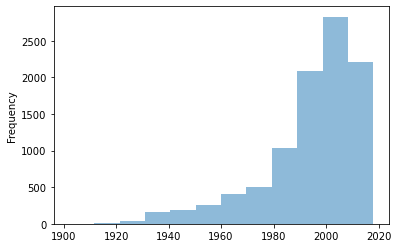

In [73]:
pd.to_numeric(movies['release_year']).plot.hist(bins=12, alpha=0.5)

In [74]:
movies["description"] = None
movies["image_url"] = None

movies.head()

,movieId,title,release_year,description,image_url
0,1,Toy Story,1995,None,None
1,2,Jumanji,1995,None,None
2,3,Grumpier Old Men,1995,None,None
3,4,Waiting to Exhale,1995,None,None
4,5,Father of the Bride Part II,1995,None,None


In [75]:
def get_image_url_and_synopsis_by_title(imdbId):
    image_url = None
    url = 'https://www.imdb.com/title/' + imdbId
    page = requests.get(url).text
    soup = BeautifulSoup(page, 'lxml')

    i = 0
    for raw_img in soup.find_all('img'):
        link = raw_img.get('src')
        if 'images' in link:
            i+=1
            if i == 2:
                image_url = link
                break

    plot = soup.find_all("div", {"class": "plot_summary"})
    metadata = soup.find_all("div", {"class": "summary_text"})
    synopsis = None

    if plot:
        if metadata:
            synopsis = metadata[0].text

    return image_url, synopsis

get_image_url_and_synopsis_by_title("tt0056801")

('https://m.media-amazon.com/images/M/MV5BMTQ4MTA0NjEzMF5BMl5BanBnXkFtZTgwMDg4NDYxMzE@._V1_UY268_CR5,0,182,268_AL_.jpg',
 '\n                    A harried movie director retreats into his memories and fantasies.\n            ')

In [76]:
links =  pd.read_csv('./dataset/links.csv')
del links['tmdbId']
links.head()

,movieId,imdbId
0,1,114709
1,2,113497
2,3,113228
3,4,114885
4,5,113041


In [77]:
links['imdbId'] = links['imdbId'].astype(str)
links

,movieId,imdbId
0,1,114709
1,2,113497
2,3,113228
3,4,114885
4,5,113041
...,...,...
9737,193581,5476944
9738,193583,5914996
9739,193585,6397426
9740,193587,8391976


In [78]:
def makeImdbIdValid(imdbId):
    imdbId = str(imdbId)
    while len(imdbId) < 7:
        imdbId = '0' + imdbId
    
    return 'tt' + imdbId
makeImdbIdValid('114709')

'tt0114709'

In [79]:
links[links['movieId'] == 1]['imdbId'].tolist()[0]

'114709'

In [80]:
# for index, row in movies.iterrows():
#     imdbId = makeImdbIdValid(links[links['movieId'] == row['movieId']]['imdbId'].tolist()[0])
#     image_url, description = get_image_url_and_synopsis_by_title(imdbId)
#     print(image_url)
#     movies.at[index, 'image_url'] = image_url
#     movies.at[index, 'description'] = description
    
# movies.head()

In [81]:
# movies.to_csv('filme.csv', index=False) 

In [82]:
movies =  pd.read_csv('./filme.csv')

In [83]:
movies.head()

,movieId,title,release_year,description,image_url
0,1,Toy Story,1995.0,A cowboy doll is profoundly threatened and jea...,https://m.media-amazon.com/images/M/MV5BMDU2ZW...
1,2,Jumanji,1995.0,When two kids find and play a magical board ga...,https://m.media-amazon.com/images/M/MV5BZTk2Zm...
2,3,Grumpier Old Men,1995.0,John and Max resolve to save their beloved bai...,https://m.media-amazon.com/images/M/MV5BMjQxM2...
3,4,Waiting to Exhale,1995.0,"Based on Terry McMillan's novel, this film fol...",https://m.media-amazon.com/images/M/MV5BYzcyMD...
4,5,Father of the Bride Part II,1995.0,George Banks must deal not only with the pregn...,https://m.media-amazon.com/images/M/MV5BOTEyNz...


In [84]:
# movies[movies['movieId'] == 720]['description']

In [85]:
# for index, row in movies.iterrows():
#     description = movies[movies['movieId'] == row['movieId']]['description'].tolist()
#     print(row['movieId'])
#     if len(description) > 0 and description[0]!= 'NaN':
#         movies.at[index, 'description'] = str(description[0]).strip()
    
# movies.head()

In [86]:
# movies.to_csv('filme.csv', index=False) 